In [15]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from comp.envs.comp_v0 import Comp
# from pettingzoo.test import parallel_api_test

In [2]:

# parallel_api_test(Comp())

In [3]:
env = Comp()

In [4]:
# both always cooperate
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

np.sum(np.array(episode_rews), axis=0)

array([-354, -318])

In [5]:
# both always defect
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

np.sum(np.array(episode_rews), axis=0)

array([-1000, -1000])

In [6]:
# player1 defects, player2 cooperates
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

np.sum(np.array(episode_rews), axis=0)

array([-250, -871])

In [39]:
# player1 cooperates, player2 defects
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

np.sum(np.array(episode_rews), axis=0)

array([-867, -279])

In [40]:
arr = np.array(episode_rews)

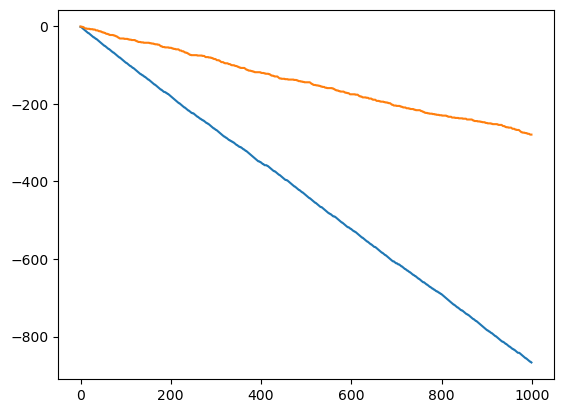

In [44]:
plt.plot(arr.cumsum(axis=0))

In [38]:
arr.shape

(1000, 2)